In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from cmcrameri import cm
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

from plot_utils import rcparams
plt.rcParams.update(rcparams)

In [2]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values at low density
# http://arxiv.org/abs/2111.05350
chiEFT_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

In [3]:
muL, nL, pL = chiEFT_values['stiff']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

X = 2
muH = 2.6
pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)

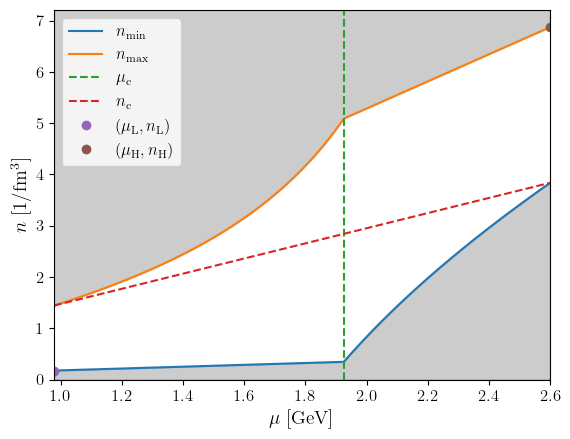

In [4]:
mu_array = np.linspace(muL, muH, 1000)

# There are functions to plot the constraints in the chemical potential vs
# baryon number density plane...
fig, ax = constraints.plot_mu_n(mu_array)

In [5]:
collated_eos = pd.read_csv('../data/eos-draws-default/eos-draws-default.csv')
collated_ntov = to_nucleons_per_cubic_femtometre(collated_eos['ntov'])

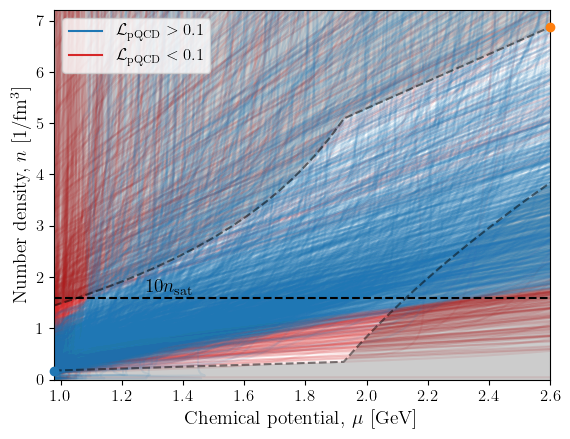

In [6]:
n0 = 10 # nsat
pqcd_weights = np.loadtxt(
    f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{n0}nsat_Xmarg_mu2.6.dat'
)

fig, ax = plt.subplots()

# Theory predictions

ax.plot(constraints.muL, constraints.nL, 'o', c='C0', zorder=11, clip_on=False)
ax.plot(constraints.muH, constraints.nH, 'o', c='C1', zorder=11, clip_on=False)

ylim = [0, ax.get_ylim()[1]]

# Constraints

ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2, lw=0)
ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2, lw=0)

ax.plot(mu_array, constraints.nmin(mu_array), c='k', ls='--', alpha=0.5, zorder=10)
ax.plot(mu_array, constraints.nmax(mu_array), c='k', ls='--', alpha=0.5, zorder=10)

ax.axhline(n0*nsat, c='k', ls='--', zorder=10)
ax.text(constraints.muL+0.3, n0*nsat+0.01, rf'${n0}n_\mathrm{{sat}}$', ha='left', va='bottom', fontsize=14)

# EOS draws

for eos, w in zip(collated_eos.eos[:2000], pqcd_weights[:2000]):

    eos = int(eos)
    df = pd.read_csv(
        '../data/eos-draws-default/mrgagn/'
        f'DRAWmod1000-{eos//1000:06}/eos-draw-{eos:06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    chemical_potential = (energy_density + pressure)/number_density

    ax.plot(
        chemical_potential, 
        number_density, 
        alpha=0.1, 
        c='C0' if w > 0.1 else 'C3',
        zorder=1 if w > 0.1 else 0
        )

# ---
    
handles = [
    plt.Line2D([0], [0], color='C0', label='$\mathcal{L}_\mathrm{pQCD} > 0.1$'),
    plt.Line2D([0], [0], color='C3', label='$\mathcal{L}_\mathrm{pQCD} < 0.1$'),
]
ax.legend(handles=handles, loc='upper left')

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
ax.set_ylabel(r'Number density, $n$ [1/fm$^3$]')

ax.set_xlim(constraints.muL, constraints.muH)
ax.set_ylim(ylim)

fig.savefig('figures/likelihood/mu-n.png', bbox_inches='tight', dpi=300)

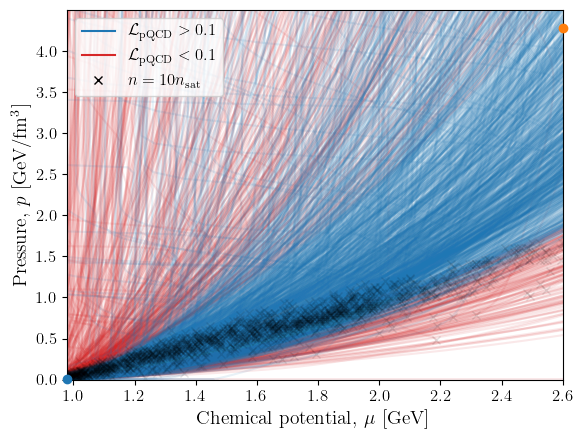

In [7]:
n0 = 10 # nsat
pqcd_weights = np.loadtxt(
    f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{n0}nsat_Xmarg_mu2.6.dat'
)

chosen_pressure = 1 # GeV/fm^3

fig, ax = plt.subplots()

# Theory predictions

ax.plot(constraints.muL, constraints.pL, 'o', c='C0', zorder=11, clip_on=False)
ax.plot(constraints.muH, constraints.pH, 'o', c='C1', zorder=11, clip_on=False)

ylim = [0, ax.get_ylim()[1]]

# EOS draws

low_l_mus = []
high_l_mus = []

low_l_epsilons = []
high_l_epsilons = []

for eos, w in zip(collated_eos.eos[:2000], pqcd_weights[:2000]):

    eos = int(eos)
    df = pd.read_csv(
        '../data/eos-draws-default/mrgagn/'
        f'DRAWmod1000-{eos//1000:06}/eos-draw-{eos:06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    chemical_potential = (energy_density + pressure)/number_density

    # Evaluate index
    index = np.argmin(np.abs(number_density - n0*nsat))

    # Pressure index
    pressure_index = np.argmin(np.abs(pressure - chosen_pressure))

    if w > 0.1:
        high_l_mus.append(chemical_potential[pressure_index])
        high_l_epsilons.append(energy_density[pressure_index])
    else:
        low_l_mus.append(chemical_potential[pressure_index])
        low_l_epsilons.append(energy_density[pressure_index])

    ax.plot(
        chemical_potential, 
        pressure, 
        alpha=0.1, 
        c='C0' if w > 0.1 else 'C3',
        zorder=1 if w > 0.1 else 0
        )
    
    ax.plot(
        chemical_potential[index], 
        pressure[index], 
        'x', 
        alpha=0.1, 
        c='k',
        )

# ---
    
handles = [
    plt.Line2D([0], [0], color='C0', label='$\mathcal{L}_\mathrm{pQCD} > 0.1$'),
    plt.Line2D([0], [0], color='C3', label='$\mathcal{L}_\mathrm{pQCD} < 0.1$'),
    plt.Line2D([0], [0], marker='x', color='k', label='$n = 10n_\mathrm{sat}$', ls=''),
]
ax.legend(handles=handles, loc='upper left')

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_xlim(constraints.muL, constraints.muH)
ax.set_ylim(ylim)

fig.savefig('figures/likelihood/mu-p.png', bbox_inches='tight', dpi=300)

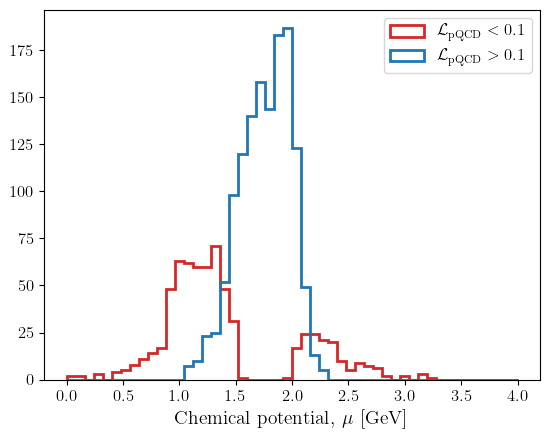

In [8]:
fig, ax = plt.subplots()

ax.hist(
    low_l_mus, 
    bins=50, 
    range=(0, 4),
    histtype='step', 
    color='C3', 
    lw=2, 
    label='$\mathcal{L}_\mathrm{pQCD} < 0.1$'
)
ax.hist(
    high_l_mus, 
    bins=50, 
    range=(0, 4),
    histtype='step', 
    color='C0', 
    lw=2, 
    label='$\mathcal{L}_\mathrm{pQCD} > 0.1$'
)

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')

ax.legend();

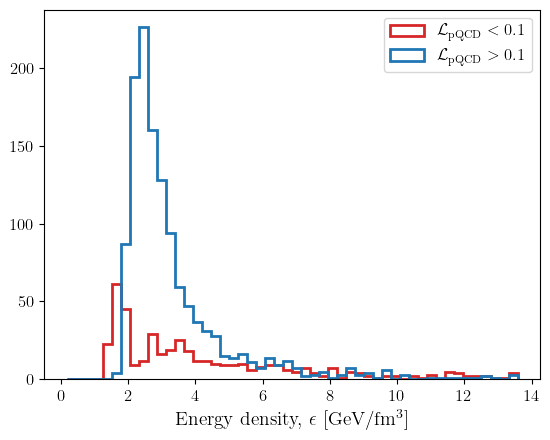

In [9]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

ax.hist(
    low_l_epsilons, 
    bins=50, 
    range=(constraints.epsilonL, constraints.epsilonH),
    histtype='step', 
    color='C3', 
    lw=2, 
    label='$\mathcal{L}_\mathrm{pQCD} < 0.1$'
    )
ax.hist(
    high_l_epsilons, 
    bins=50, 
    range=(constraints.epsilonL, constraints.epsilonH),
    histtype='step', 
    color='C0', 
    lw=2, 
    label='$\mathcal{L}_\mathrm{pQCD} > 0.1$'
    )

ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')

ax.legend();

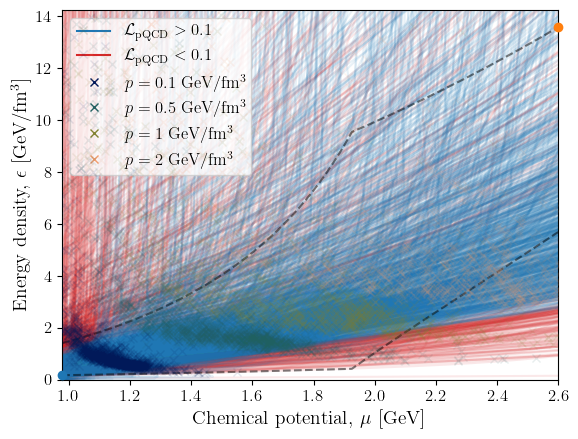

In [10]:
n0 = 10 # nsat
pqcd_weights = np.loadtxt(
    f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{n0}nsat_Xmarg_mu2.6.dat'
)

chosen_pressures = [0.1, 0.5, 1, 2] # GeV/fm^3

fig, ax = plt.subplots()

# Theory predictions

ax.plot(constraints.muL, constraints.epsilonL, 'o', c='C0', zorder=11, clip_on=False)
ax.plot(constraints.muH, constraints.epsilonH, 'o', c='C1', zorder=11, clip_on=False)

ylim = [0, ax.get_ylim()[1]]

# Constraints

ax.plot(mu_array, constraints.epsilon_min(mu_array), c='k', ls='--', alpha=0.5, zorder=10)
ax.plot(mu_array, constraints.epsilon_max(mu_array), c='k', ls='--', alpha=0.5, zorder=10)

# EOS draws

for eos, w in zip(collated_eos.eos[:2000], pqcd_weights[:2000]):

    eos = int(eos)
    df = pd.read_csv(
        '../data/eos-draws-default/mrgagn/'
        f'DRAWmod1000-{eos//1000:06}/eos-draw-{eos:06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    chemical_potential = (energy_density + pressure)/number_density

    # Evaluate index
    index = np.argmin(np.abs(number_density - n0*nsat))

    for i, chosen_pressure in enumerate(chosen_pressures):
        p_index = np.argmin(np.abs(pressure - chosen_pressure))
        
        ax.plot(
            chemical_potential[p_index], 
            energy_density[p_index], 
            'x', 
            alpha=0.1, 
            c=cm.batlow(i/len(chosen_pressures)),
            zorder=11
            )

    ax.plot(
        chemical_potential, 
        energy_density, 
        alpha=0.1, 
        c='C0' if w > 0.1 else 'C3',
        zorder=1 if w > 0.1 else 0
        )

# ---
    
handles = [
    plt.Line2D([0], [0], color='C0', label='$\mathcal{L}_\mathrm{pQCD} > 0.1$'),
    plt.Line2D([0], [0], color='C3', label='$\mathcal{L}_\mathrm{pQCD} < 0.1$'),
]
pressure_handles = [
    plt.Line2D(
        [0], [0], 
        marker='x', 
        ls='', 
        color=cm.batlow(i/len(chosen_pressures)), 
        label=f'$p = {p}$ GeV/fm$^3$'
    )
    for i, p in enumerate(chosen_pressures)
]
ax.legend(handles=handles+pressure_handles, loc='upper left')

ax.set_xlabel(r'Chemical potential, $\mu$ [GeV]')
ax.set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')

ax.set_xlim(constraints.muL, constraints.muH)
ax.set_ylim(ylim)

fig.savefig('figures/likelihood/mu-epsilon.png', bbox_inches='tight', dpi=300)

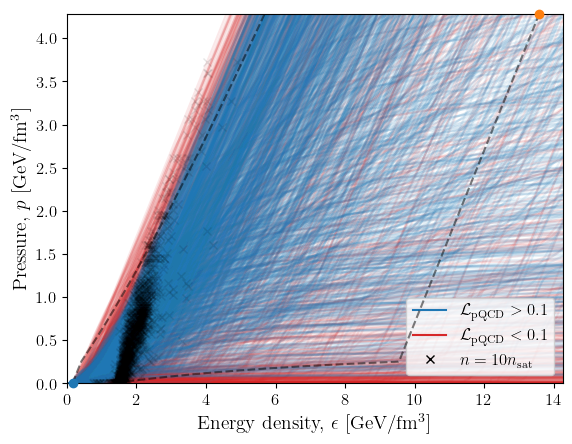

In [11]:
n0 = 10 # nsat
pqcd_weights = np.loadtxt(
    f'../data/eos-draws-default/pqcd-weights/pqcd_weights_{n0}nsat_Xmarg_mu2.6.dat'
)

fig, ax = plt.subplots()

# Theory predictions

ax.plot(constraints.epsilonL, constraints.pL, 'o', c='C0', zorder=11, clip_on=False)
ax.plot(constraints.epsilonH, constraints.pH, 'o', c='C1', zorder=11, clip_on=False)

xlim = ax.get_xlim()

ax.plot(
    constraints.epsilon_min(mu_array), 
    constraints.pmax(mu_array, constraints.nmin(mu_array)), 
    c='k', 
    ls='--', 
    alpha=0.5, 
    zorder=10
    )
ax.plot(
    constraints.epsilon_max(mu_array), 
    constraints.pmin(mu_array), 
    c='k', 
    ls='--', 
    alpha=0.5, 
    zorder=10
    )

# EOS draws

for eos, w in zip(collated_eos.eos[:2000], pqcd_weights[:2000]):

    eos = int(eos)
    df = pd.read_csv(
        '../data/eos-draws-default/mrgagn/'
        f'DRAWmod1000-{eos//1000:06}/eos-draw-{eos:06}.csv'
    )

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    chemical_potential = (energy_density + pressure)/number_density

    # Evaluate index
    index = np.argmin(np.abs(number_density - n0*nsat))

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.1, 
        c='C0' if w > 0.1 else 'C3',
        zorder=1 if w > 0.1 else 0.9
        )
    
    ax.plot(
        energy_density[index], 
        pressure[index], 
        'x', 
        alpha=0.1, 
        c='k',
        )

# ---
    
handles = [
    plt.Line2D([0], [0], color='C0', label='$\mathcal{L}_\mathrm{pQCD} > 0.1$'),
    plt.Line2D([0], [0], color='C3', label='$\mathcal{L}_\mathrm{pQCD} < 0.1$'),
    plt.Line2D([0], [0], marker='x', color='k', label='$n = 10n_\mathrm{sat}$', ls=''),
]
ax.legend(handles=handles, loc='lower right')

ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

ax.set_xlim((0, xlim[1]))
ax.set_ylim((0, constraints.pH))

fig.savefig('figures/likelihood/epsilon-p.png', bbox_inches='tight', dpi=300)